In [2]:

import io
import itertools

import numpy as np
import sklearn.metrics

import tensorflow as tf
from tensorboard.plugins.hparams import api as hp

import matplotlib.pyplot as plt



In [22]:
## Global Variables
BUFFER_SIZE = 4113
EPOCHS = 15
BATCH_SIZE= 64

In [4]:
#Load Data
input_data = np.load('/kaggle/input/ship-and-iceberg-images/input_data.npz')

In [5]:
type(input_data)

numpy.lib.npyio.NpzFile

In [6]:
input_data.files

['X_train', 'Y_train', 'X_validation', 'Y_validation']

In [13]:
X_train = input_data['X_train']
Y_train = input_data['Y_train']
X_validation = input_data['X_validation']
Y_validation = input_data['Y_validation']


In [14]:
np.unique(Y_train)

array([0, 1])

In [15]:
# Split Data
from sklearn.model_selection import train_test_split

# Split into training and testing data
X_train,X_test, Y_train , Y_test = train_test_split(X_train, Y_train, test_size=0.20, random_state=42)


In [16]:
print( X_train.shape)
print( Y_train.shape)
print( X_validation.shape)
print( Y_validation.shape)
print( X_test.shape)
print( Y_test.shape)

(3290, 75, 75, 3)
(3290,)
(100, 75, 75, 3)
(100,)
(823, 75, 75, 3)
(823,)


Text(0.5, 1.0, 'Iceberg')

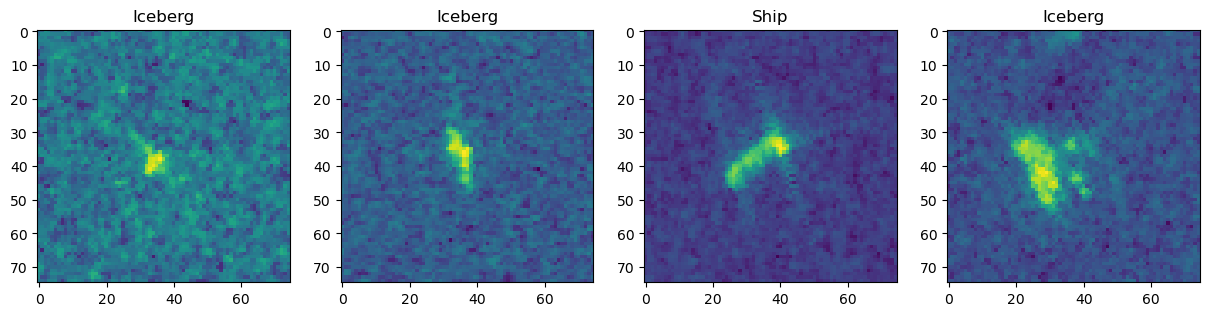

In [17]:
x,y,z,l = 20,50,100,300
labels = ['Ship','Iceberg']  #0 is no iceberg(ship) and 1 is iceberg


plt.figure(figsize=(15,10))

plt.subplot(1, 4, 1)
plt.imshow(X_train[x,:,:,2])
plt.title (labels[int(Y_train[x])])

plt.subplot(1, 4, 2)
plt.imshow(X_train[y,:,:,2])
plt.title (labels[int(Y_train[y])])


plt.subplot(1, 4, 3)
plt.imshow(X_train[z,:,:,2])
plt.title (labels[int(Y_train[z])])


plt.subplot(1, 4, 4)
plt.imshow(X_train[l,:,:,2])
plt.title (labels[int(Y_train[l])])

In [18]:
images_train,labels_train =X_train , Y_train
images_val,labels_val = X_validation , Y_validation
images_test,labels_test = X_test , Y_test

In [23]:
# Defining the hyperparameters we would tune, and their values to be tested
HP_FILTER_SIZE = hp.HParam('filter_size', hp.Discrete([5,7]))
HP_FILTER_NUM = hp.HParam('filters_number', hp.Discrete([64,128]))
HP_FILTER_SIZE_2 = hp.HParam('filter_size_2', hp.Discrete([3,5]))  # of the 2nd Conv Layer
HP_DENSE_SIZE = hp.HParam('dense_size', hp.Discrete([256,512]))



METRIC_ACCURACY = 'accuracy'

# Logging setup info
with tf.summary.create_file_writer(r'Logs/Model 1/hparam_tuning/').as_default():
    hp.hparams_config(
        hparams=[HP_FILTER_SIZE, HP_FILTER_NUM, HP_FILTER_SIZE_2],
        metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
    )

In [24]:
# Wrapping our model and training in a function
def train_test_model(hparams, session_num):
    
    # Outlining the model/architecture of our CNN
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(hparams[HP_FILTER_NUM], hparams[HP_FILTER_SIZE], activation='relu', 
                               input_shape=(75,75,3)),

        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Conv2D(hparams[HP_FILTER_NUM], hparams[HP_FILTER_SIZE_2], activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(hparams[HP_DENSE_SIZE], activation='relu'),

        tf.keras.layers.Dense(2)
    ])
    
    # Defining the loss function
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    # Compiling the model
    model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

    # Defining the logging directory
    log_dir = "logs\\Model 1\\fit\\" + "run-{}".format(session_num)
    
    def plot_confusion_matrix(cm, class_names):
        """
        Returns a matplotlib figure containing the plotted confusion matrix.

        Args:
          cm (array, shape = [n, n]): a confusion matrix of integer classes
          class_names (array, shape = [n]): String names of the integer classes
        """
        figure = plt.figure(figsize=(12, 12))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title("Confusion matrix")
        plt.colorbar()
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=45)
        plt.yticks(tick_marks, class_names)

        # Normalize the confusion matrix.
        cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

        # Use white text if squares are dark; otherwise black.
        threshold = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            color = "white" if cm[i, j] > threshold else "black"
            plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        return figure
    
     
    
    
    def plot_to_image(figure):
        """Converts the matplotlib plot specified by 'figure' to a PNG image and
        returns it. The supplied figure is closed and inaccessible after this call."""
        # Save the plot to a PNG in memory.
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        # Closing the figure prevents it from being displayed directly inside
        # the notebook.
        plt.close(figure)
        buf.seek(0)
        # Convert PNG buffer to TF image
        image = tf.image.decode_png(buf.getvalue(), channels=4)
        # Add the batch dimension
        image = tf.expand_dims(image, 0)
        return image
    
    
    # Defining a file writer for Confusion Matrix logging purposes
    file_writer_cm = tf.summary.create_file_writer(log_dir + '/cm') 
    
    
    def log_confusion_matrix(epoch, logs):
        # Use the model to predict the values from the validation dataset.
        test_pred_raw = model.predict(images_val)
        test_pred = np.argmax(test_pred_raw, axis=1)

        # Calculate the confusion matrix.
        cm = sklearn.metrics.confusion_matrix(labels_val, test_pred)
        # Log the confusion matrix as an image summary.
        figure = plot_confusion_matrix(cm, class_names=['Ship', 'Iceberg '])
        cm_image = plot_to_image(figure)

        # Log the confusion matrix as an image summary.
        with file_writer_cm.as_default():
            tf.summary.image("Confusion Matrix", cm_image, step=epoch)
    
    
    # Define the Tensorboard and Confusion Matrix callbacks.
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=0)
    cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

    
    # Defining early stopping to prevent overfitting
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor = 'val_loss',
        mode = 'auto',
        min_delta = 0,
        patience = 2,
        verbose = 0, 
        restore_best_weights = True
    )
    
    # Training the model
    model.fit(
        images_train,
        labels_train,
        epochs = EPOCHS,
        batch_size = BATCH_SIZE,
        callbacks = [tensorboard_callback, cm_callback, early_stopping],
        validation_data = (images_val,labels_val),
        verbose = 1
    )
    
    # Evaluating the model's performance on the validation set
    _, accuracy = model.evaluate(images_val,labels_val)
    
    # Saving the current model for future reference
    model.save(r"saved_models\Model 1\Run-{}".format(session_num))
    
    return accuracy

In [25]:
# Creating a function to log the resuls
def run(log_dir, hparams, session_num):
    
    with tf.summary.create_file_writer(log_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        accuracy = train_test_model(hparams, session_num)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [27]:
session_num = 1

for filter_size in HP_FILTER_SIZE.domain.values:
    for filter_num in HP_FILTER_NUM.domain.values:
        for filter_size_2 in HP_FILTER_SIZE_2.domain.values:
            for dense_size in HP_DENSE_SIZE.domain.values:
                      hparams = {
                          HP_FILTER_SIZE: filter_size,
                          HP_FILTER_NUM: filter_num,
                          HP_FILTER_SIZE_2: filter_size_2,
                          HP_DENSE_SIZE: dense_size
                      }

                      run_name = "run-%d" % session_num
                      print('--- Starting trial: %s' % run_name)
                      print({h.name: hparams[h] for h in hparams})
                      run('Logs/Model 1/hparam_tuning/' + run_name, hparams, session_num)

                      session_num += 1

--- Starting trial: run-1
{'filter_size': 5, 'filters_number': 64, 'filter_size_2': 3, 'dense_size': 256}
Epoch 1/15
52/52 [==============================] - 4s 50ms/step - loss: 0.6427 - accuracy: 0.5985 - val_loss: 0.5211 - val_accuracy: 0.7700
Epoch 2/15
52/52 [==============================] - 2s 43ms/step - loss: 0.4022 - accuracy: 0.8091 - val_loss: 0.3325 - val_accuracy: 0.8400
Epoch 3/15
52/52 [==============================] - 2s 43ms/step - loss: 0.2940 - accuracy: 0.8702 - val_loss: 0.2890 - val_accuracy: 0.8400
Epoch 4/15
52/52 [==============================] - 2s 44ms/step - loss: 0.2359 - accuracy: 0.9027 - val_loss: 0.2759 - val_accuracy: 0.8700
Epoch 5/15
52/52 [==============================] - 2s 43ms/step - loss: 0.2018 - accuracy: 0.9137 - val_loss: 0.2745 - val_accuracy: 0.8800
Epoch 6/15
52/52 [==============================] - 2s 45ms/step - loss: 0.1559 - accuracy: 0.9347 - val_loss: 0.2077 - val_accuracy: 0.9200
Epoch 7/15
52/52 [==============================

In [34]:
# !kill 2632
# # %load_ext tensorboard
# %tensorboard --logdir "Logs/Model 1/hparam_tuning"

unfortunately , Tensorboard has temporarily been disabled in new docker images because it was slowing down startup of all notebooks (even ones that did not use it).

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir "logs/Model 1/fit" 

In [42]:
# The Run ahcieve higher validation Acc was run-11
# {'filter_size': 7, 'filters_number': 64, 'filter_size_2': 5, 'dense_size': 256}

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, 7, activation='relu', 
                           input_shape=(75,75,3)),

    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(256, activation='relu'),

    tf.keras.layers.Dense(2)
])

# Defining the loss function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Compiling the model
model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

# Training the model
model.fit(
    images_train,
    labels_train,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    validation_data = (images_val,labels_val),
    verbose = 1
)


Epoch 1/15
52/52 [==============================] - 2s 17ms/step - loss: 0.6789 - accuracy: 0.5456 - val_loss: 0.6266 - val_accuracy: 0.6100
Epoch 2/15
52/52 [==============================] - 1s 14ms/step - loss: 0.5263 - accuracy: 0.7398 - val_loss: 0.4009 - val_accuracy: 0.8500
Epoch 3/15
52/52 [==============================] - 1s 14ms/step - loss: 0.3624 - accuracy: 0.8495 - val_loss: 0.3136 - val_accuracy: 0.8800
Epoch 4/15
52/52 [==============================] - 1s 14ms/step - loss: 0.3030 - accuracy: 0.8790 - val_loss: 0.3311 - val_accuracy: 0.8600
Epoch 5/15
52/52 [==============================] - 1s 14ms/step - loss: 0.2619 - accuracy: 0.8897 - val_loss: 0.3243 - val_accuracy: 0.8800
Epoch 6/15
52/52 [==============================] - 1s 14ms/step - loss: 0.2400 - accuracy: 0.9040 - val_loss: 0.3022 - val_accuracy: 0.8500
Epoch 7/15
52/52 [==============================] - 1s 14ms/step - loss: 0.2105 - accuracy: 0.9170 - val_loss: 0.2691 - val_accuracy: 0.8500
Epoch 8/15
52

In [44]:
test_loss, test_accuracy = model.evaluate(images_test,labels_test)

26/26 [==============================] - 0s 5ms/step - loss: 0.4574 - accuracy: 0.8591
Test loss: 0.46. Test accuracy: 85.91%


In [48]:
# Printing the test results
print('Test loss: {0:.4f}. Test accuracy: {1:.2f}%'.format(test_loss, test_accuracy*100.))

Test loss: 0.4574. Test accuracy: 85.91%
